In [9]:
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import scipy as sp
import tensorflow as tf
import platform
import pathlib
import random
from tensorflow import keras
import math
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print(f"SciPy {sp.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: Windows-10-10.0.22621-SP0
Tensor Flow Version: 2.10.0
Keras Version: 2.10.0

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
Pandas 1.5.1
Scikit-Learn 1.1.3
SciPy 1.9.3
GPU is available


In [10]:
# Variables and params
BATCH_SIZE = 256
NUM_EPOCH = 40
BUFFER_SIZE = 2048*2#math.ceil( (8*1024*1024*1024*7)/(256*256*3*8) )#how many images in 7GB of VRAM

train_root = pathlib.Path('../../FruitScale/dataextended/Training')
train_root = train_root.resolve()

test_root = pathlib.Path('../../FruitScale/dataextended/Test')
test_root = test_root.resolve()

random.seed(42)

In [11]:
# Useful functions
def create_image_tensor(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    grayscale = tf.image.rgb_to_grayscale(image)
    hsv = tf.image.rgb_to_hsv(image)
    res = tf.concat([hsv, grayscale], 2)
    #res = image
    return res

def augment(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_hue(image, 0.02)
    image = tf.image.random_saturation(image, 0.9, 1.2)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return create_image_tensor(image)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.rgb_to_hsv(image)
    #image = tf.image.decode_jpeg(image, channels=3)
    #image = tf.image.resize(image, [256, 256])
    return image
    #return augment(image)

In [12]:
# Setting labels and image paths
all_image_paths = list(train_root.glob('*/*'))
all_image_paths_test = list(test_root.glob('*/*'))
random.shuffle(all_image_paths)
random.shuffle(all_image_paths_test)
#print(all_image_paths[10])

total_image_count = len(all_image_paths)
total_image_count_test = len(all_image_paths_test)

validation_count = math.ceil(total_image_count * 0.20)
training_count = total_image_count - validation_count

# Training images
train_labels = [str(path.parent.name) for path in all_image_paths[0: training_count]]
train_image_path = [str(path) for path in all_image_paths[0: training_count]]
train_labels = list(dict.fromkeys(train_labels))
print("Number of train labels: " + str(len(train_labels)))
print("total training count: " + str(len(train_image_path)))
print(train_labels)

# Validation images
validation_labels = [str(path.parent.name) for path in all_image_paths[training_count:]]
validation_image_path = [str(path) for path in all_image_paths[training_count:]]
validation_labels = list(dict.fromkeys(validation_labels))
print("Number of validation labels: " + str(len(validation_labels)))
print("total validation count: " + str(len(validation_image_path)))

# Test images
test_labels = [str(path.parent.name) for path in all_image_paths_test]
test_image_path = [str(path) for path in all_image_paths_test]
test_labels = list(dict.fromkeys(test_labels))
print("Number of test labels: " + str(len(test_labels)))
print("total test count: " + str(len(test_image_path)))

#Generating index
label_to_index = dict((name, index) for index, name in enumerate(train_labels))
#print(label_to_index)

train_labels = [label_to_index[pathlib.Path(path).parent.name]
                for path in train_image_path]

validation_labels = [label_to_index[pathlib.Path(path).parent.name]
                     for path in validation_image_path]

test_labels = [label_to_index[pathlib.Path(path).parent.name]
               for path in test_image_path]

#print(len(train_labels))

Number of train labels: 131
total training count: 354080
['Pomelo Sweetie', 'Cherry Wax Red', 'Tamarillo', 'Beetroot', 'Mandarine', 'Grape Blue', 'Apple Golden 1', 'Grape White 4', 'Kiwi', 'Mangostan', 'Rambutan', 'Corn Husk', 'Lemon Meyer', 'Pear Williams', 'Blueberry', 'Cherry Rainier', 'Tomato 4', 'Pear Kaiser', 'Cactus fruit', 'Pepper Orange', 'Guava', 'Kaki', 'Potato White', 'Apple Red Yellow 2', 'Physalis with Husk', 'Watermelon', 'Walnut', 'Salak', 'Tomato 1', 'Plum 2', 'Hazelnut', 'Pepino', 'Apple Red 1', 'Grapefruit Pink', 'Peach', 'Apple Pink Lady', 'Apple Red 3', 'Pineapple', 'Peach 2', 'Pear', 'Pepper Yellow', 'Onion White', 'Pear Red', 'Corn', 'Pear Abate', 'Strawberry Wedge', 'Banana', 'Cherry Wax Yellow', 'Apple Golden 3', 'Tomato Heart', 'Strawberry', 'Apple Red Yellow 1', 'Apple Red Delicious', 'Granadilla', 'Cocos', 'Avocado', 'Tomato not Ripened', 'Pear Monster', 'Peach Flat', 'Physalis', 'Banana Lady Finger', 'Mango Red', 'Limes', 'Dates', 'Potato Sweet', 'Tangelo',

In [13]:
# Generating the training data set
train_path_ds = tf.data.Dataset.from_tensor_slices(train_image_path)
train_image_ds = train_path_ds.map(load_image, tf.data.AUTOTUNE)
train_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.uint8))

train_data = tf.data.Dataset.zip((train_image_ds, train_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

train_ds = train_data.shuffle(buffer_size=math.ceil(BUFFER_SIZE))
train_ds = train_ds.batch(BATCH_SIZE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
# Generating the validation dataset
validation_path_ds = tf.data.Dataset.from_tensor_slices(validation_image_path)
validation_image_ds = validation_path_ds.map(load_image, tf.data.AUTOTUNE)
validation_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(validation_labels, tf.uint8))

validation_data = tf.data.Dataset.zip((validation_image_ds, validation_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

validation_ds = validation_data.shuffle(buffer_size=math.ceil(BUFFER_SIZE))
validation_ds = validation_ds.batch(BATCH_SIZE)

validation_ds = validation_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Generating the test dataset
test_path_ds = tf.data.Dataset.from_tensor_slices(test_image_path)
test_image_ds = test_path_ds.map(load_image, tf.data.AUTOTUNE)
test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.uint8))

print(len(test_image_ds))
print(len(test_label_ds))

test_data = tf.data.Dataset.zip((test_image_ds, test_label_ds))

#ds = data.apply(tf.data.Dataset.shuffle(buffer_size=100000))

test_ds = test_data.shuffle(buffer_size=math.ceil(total_image_count_test))
test_ds = test_ds.batch(BATCH_SIZE)

test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

22688
22688


In [16]:
model = keras.Sequential()
model.add(keras.layers.Conv2D(filters=16, kernel_size=(5, 5), input_shape=(100,100,3), activation='relu'))
model.add(keras.layers.AvgPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.AvgPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.AvgPool2D(strides=2))
model.add(keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(keras.layers.AvgPool2D(strides=2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(131, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 96, 96, 16)        1216      
                                                                 
 average_pooling2d (AverageP  (None, 48, 48, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_6 (Conv2D)           (None, 44, 44, 32)        12832     
                                                                 
 average_pooling2d_1 (Averag  (None, 22, 22, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 18, 18, 64)        51264     
                                                                 
 average_pooling2d_2 (Averag  (None, 9, 9, 64)        

In [17]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True,)

In [18]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=NUM_EPOCH,
    validation_data=validation_ds,
    verbose=1,
    callbacks=[early_stop],
)

Epoch 1/40
1384/1384 [==============================] - 84s 58ms/step - loss: 1.6688 - accuracy: 0.4987 - val_loss: 1.0207 - val_accuracy: 0.6632
Epoch 2/40
1384/1384 [==============================] - 93s 66ms/step - loss: 0.5829 - accuracy: 0.8018 - val_loss: 0.3729 - val_accuracy: 0.8709
Epoch 3/40
1384/1384 [==============================] - 96s 69ms/step - loss: 0.3972 - accuracy: 0.8635 - val_loss: 0.3537 - val_accuracy: 0.8765
Epoch 4/40
1384/1384 [==============================] - 97s 70ms/step - loss: 0.3142 - accuracy: 0.8922 - val_loss: 0.2772 - val_accuracy: 0.9058
Epoch 5/40
1384/1384 [==============================] - 98s 70ms/step - loss: 0.2772 - accuracy: 0.9051 - val_loss: 0.1799 - val_accuracy: 0.9364
Epoch 6/40
1384/1384 [==============================] - 100s 72ms/step - loss: 0.2331 - accuracy: 0.9203 - val_loss: 0.3133 - val_accuracy: 0.8945
Epoch 7/40
1384/1384 [==============================] - 103s 74ms/step - loss: 0.2114 - accuracy: 0.9278 - val_loss: 0.1595

In [19]:
model.save("trained_CNN_HSV_with_dropout.h5")

In [20]:
loss, acc, *is_anything_else_being_returned = model.evaluate(test_ds)
print('Loss:', loss)
print('Accuracy:', acc)

89/89 [==============================] - 8s 29ms/step - loss: 0.2369 - accuracy: 0.9573
Loss: 0.23688764870166779
Accuracy: 0.9573342800140381


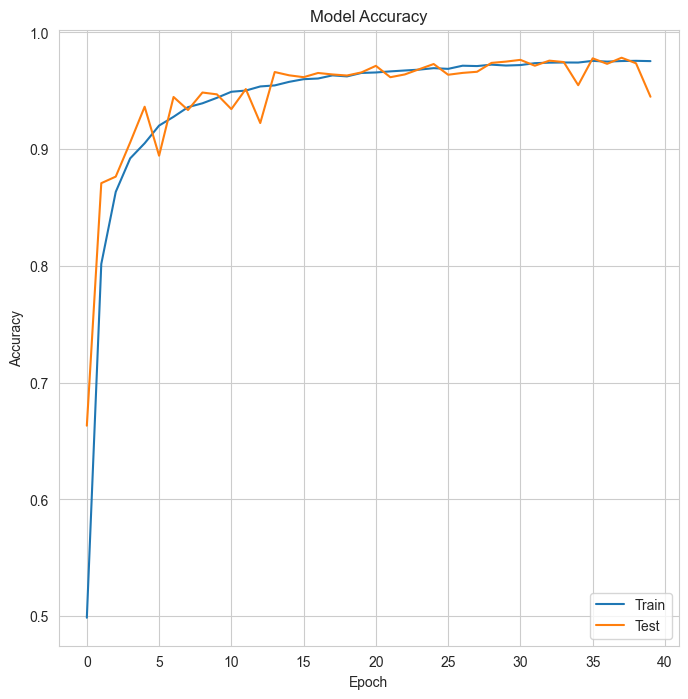

In [21]:

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

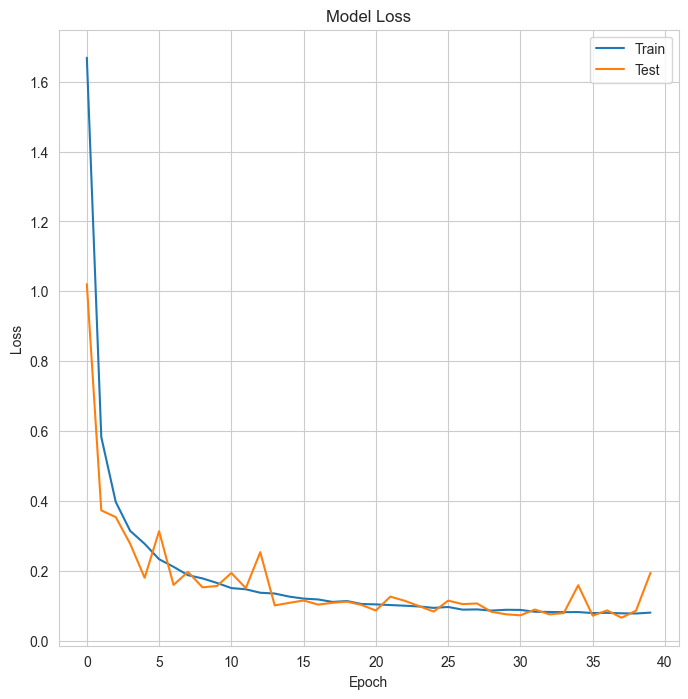

In [22]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [23]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

print(confusion_matrix(y_true=correct_labels, y_pred=predicted_labels))

5/5 [==============================] - 0s 4ms/step
[[153   0   0 ...   0   0   0]
 [  0 164   0 ...   0   0   0]
 [  0   0 166 ...   0   0   0]
 ...
 [  0   0   0 ... 133   0   0]
 [  0   0   0 ...   0  64   0]
 [  0   0   0 ...   0   0 141]]


In [24]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       153
           1       1.00      1.00      1.00       164
           2       1.00      1.00      1.00       166
           3       0.87      0.93      0.90       150
           4       1.00      0.99      0.99       166
           5       1.00      1.00      1.00       328
           6       0.99      1.00      1.00       160
           7       1.00      1.00      1.00       158
           8       1.00      1.00      1.00       156
           9       1.00      0.88      0.94       102
          10       1.00      1.00      1.00       164
          11       1.00      0.71      0.83       154
          12       1.00      0.94      0.97       166
          13       0.98      1.00      0.99       166
          14       1.00      1.00      1.00       154
          15       0.99      1.00      1.00       246
          16       0.97      1.00      0.98       160
          17       1.00    

<AxesSubplot: >

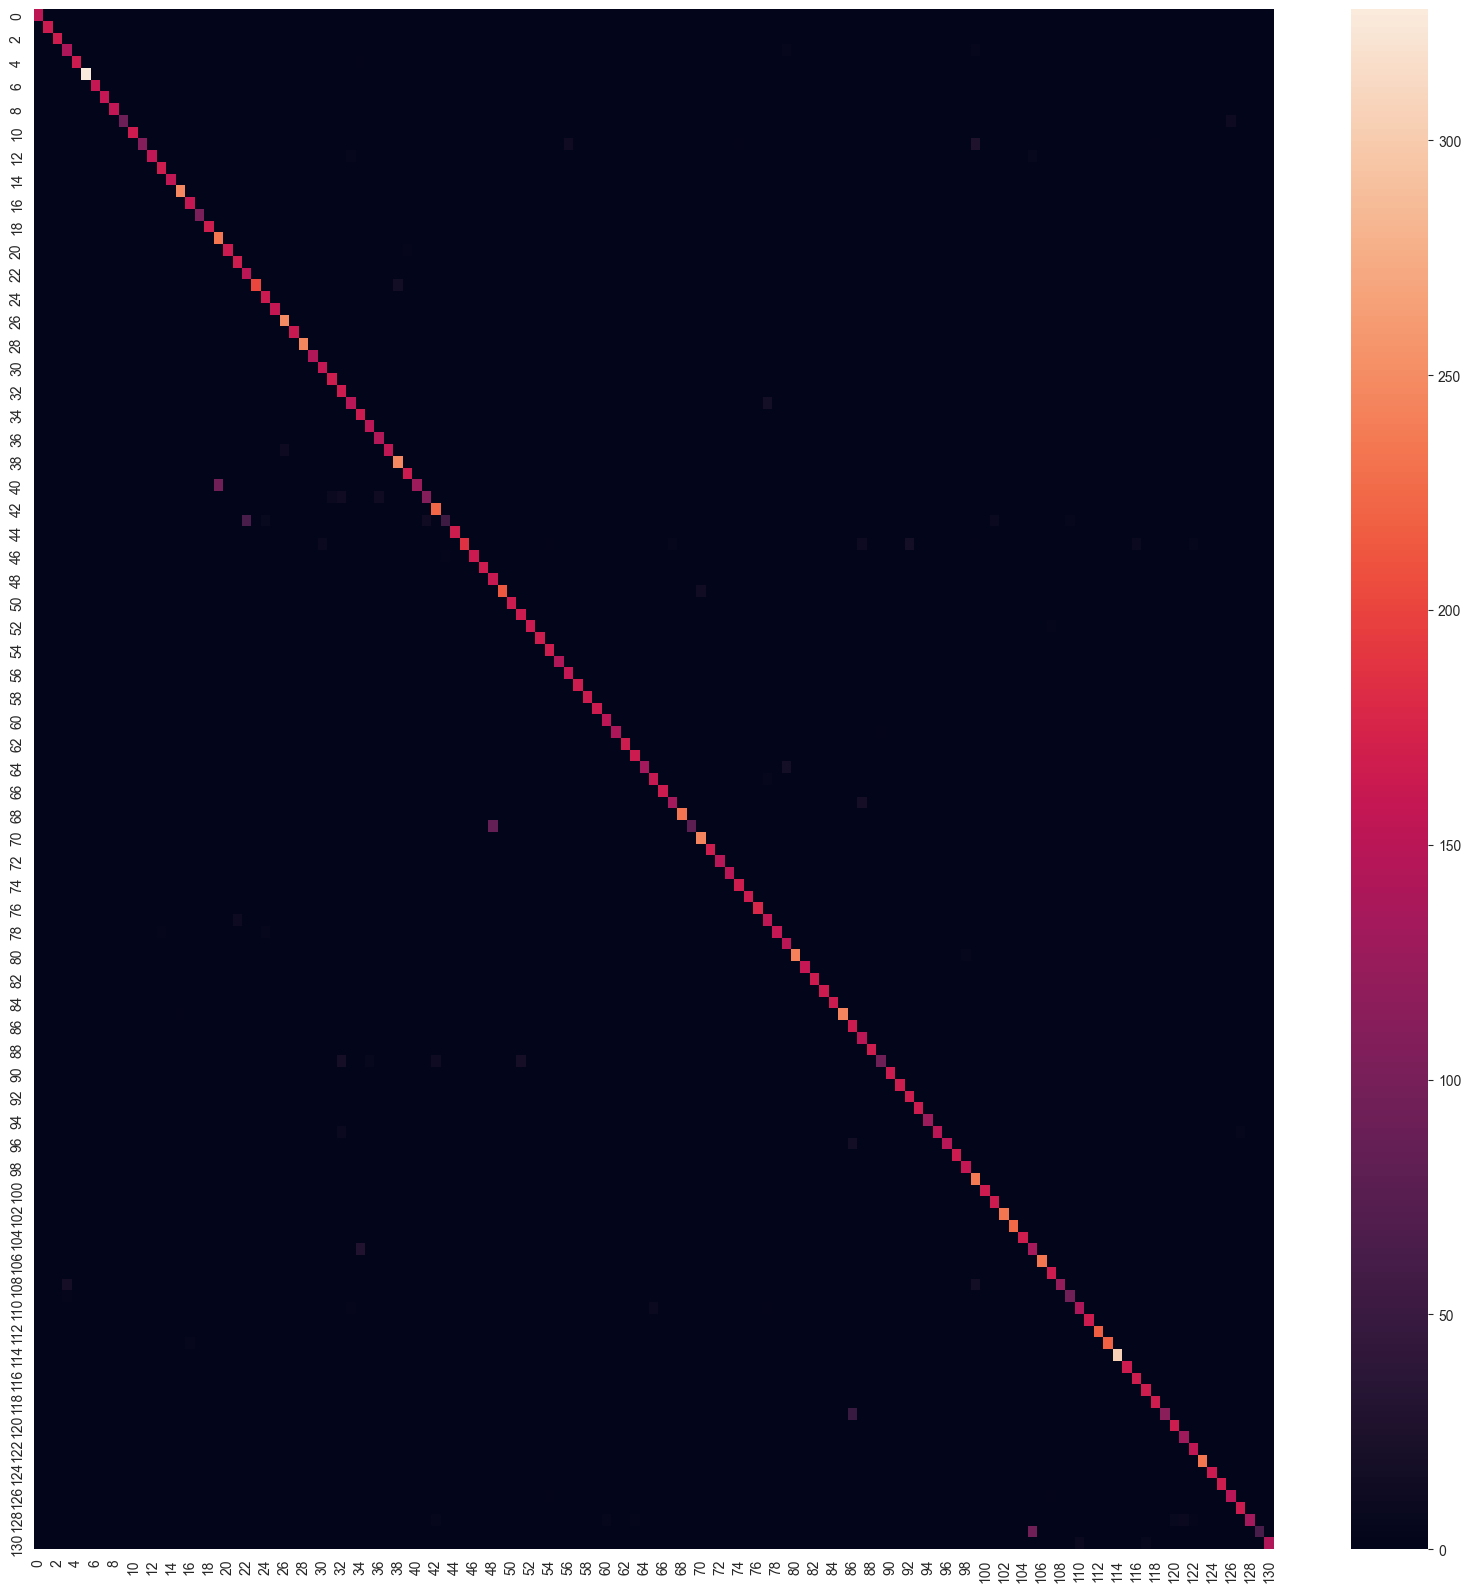

In [25]:
cf_matrix = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(cf_matrix, ax=ax,)

In [26]:
index = label_to_index#list(label_to_index.keys())
def getPredictionClass(predictions):
    i=0
    for prediction in predictions:
        if prediction > 0.0:
            k = 0
            for a,b in index.items():
                if k == i:
                    print(a + ": " + str(prediction))
                k = k + 1
        i = i+1

93.jpg
1/1 [==============================] - 0s 17ms/step
Hazelnut: 0.99
Grape Pink: 0.01


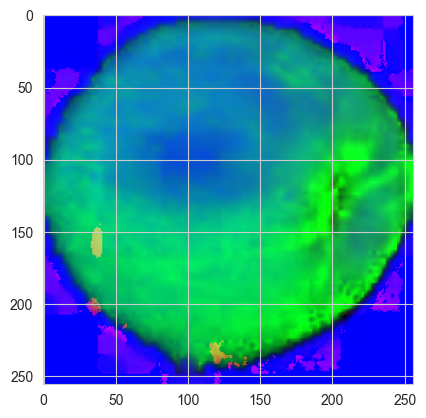

In [43]:
import cv2

x = random.choice(os.listdir(str(test_root) + '/Apple Red 3'))
print(x)
img = plt.imread(os.path.join(str(test_root) + '/Apple Red 3', x))
img = cv2.resize(img, dsize=(256, 256))
img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#img_new = keras.applications.mobilenet.preprocess_input(img)
plt.imshow(img)
img = img/256
#print(img.shape)
#print((np.expand_dims(img,0).shape))

predictions = model.predict(np.expand_dims(img,0)).round(2)[0]
#print(predictions)
getPredictionClass(predictions)